# Classification of Holiday Images 

In [1]:
# Utility
import numpy as np
import pandas as pd
import os
import time 
import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Disable jedi autocompleter
%config Completer.use_jedi = False
%matplotlib inline

# ETL
from sklearn.model_selection import train_test_split
import albumentations
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# computer vision
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

# constants
train_on_gpu = True


## EDA 

## Test data

### Ingest data

In [2]:
df_train = pd.read_csv('dataset/train.csv')

In [3]:
df_train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


### Read images and image size

In [13]:
# read size of each image and store it under dimensions "height" and "width" in df_train

path_testdata = "dataset/train/"
image_size = []
images = []
for fname in list(df_train['Image']):
    filename = os.path.join(path_testdata, fname)
    img = Image.open(filename)
    image_size.append(img.size)
    images.append(img)  
    
df_train['height'], df_train['width'] = map(list, zip(*image_size))
df_train.head()    

,Image,Class,height,width
0,image3476.jpg,Miscellaneous,80,53
1,image5198.jpg,Candle,80,63
2,image4183.jpg,Snowman,80,120
3,image1806.jpg,Miscellaneous,80,50
4,image7831.jpg,Miscellaneous,80,60


### Show sample images

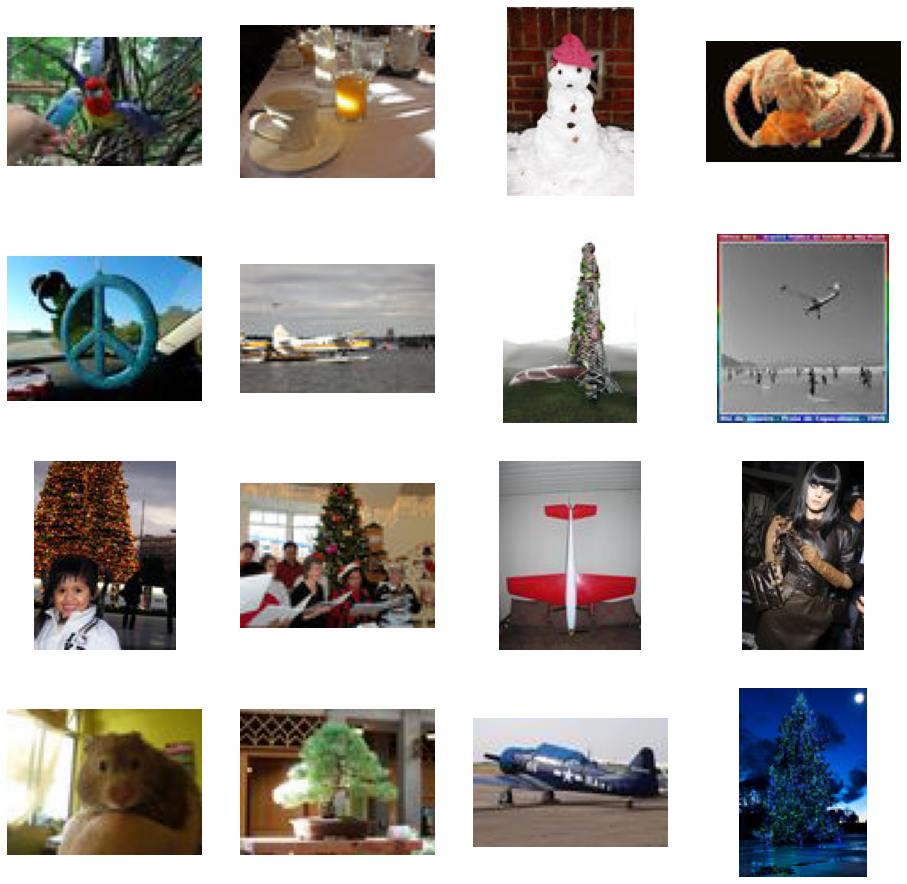

In [14]:
ncols, nrows = 4,4
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img in enumerate(images[:16]):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(img)

plt.show()  

### Class balance

From below bar plot; it is evident that data is imbalanced.

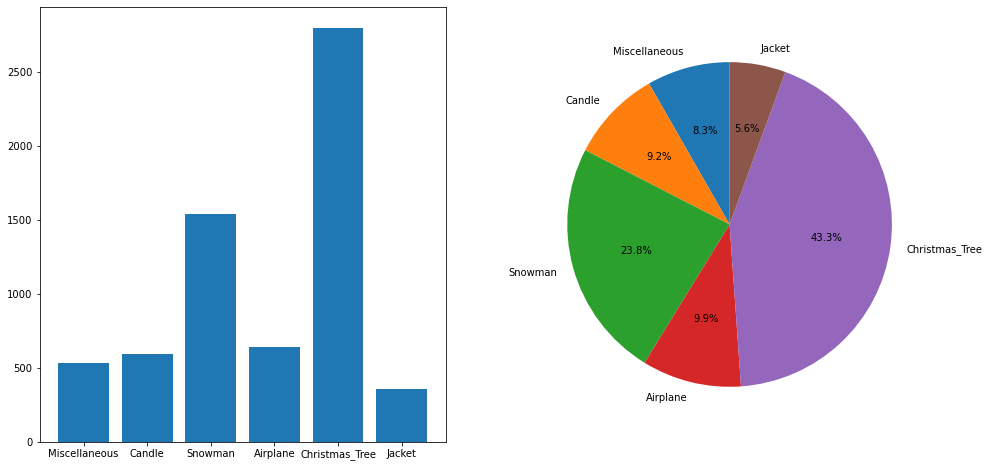

In [5]:
label = df_train['Class'].unique()
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.bar(label, df_train.groupby('Class').size())
plt.subplot(122)
plt.pie(df_train.groupby('Class').size(), labels = label, autopct='%1.1f%%', shadow=False, startangle=90)
plt.show()

### Check distribution of image height and widths

* **Heights of all iamges is constant (80 pixels)**
* whereas widths are varying over range (23:218 pixels)
* **More than 50% iamges have width in range 50:60 pixels; hence images can be resized to width 80 pixels**
    * As tradeoff, we loose resolution for few iamges having width {\lt 50 pixels} 

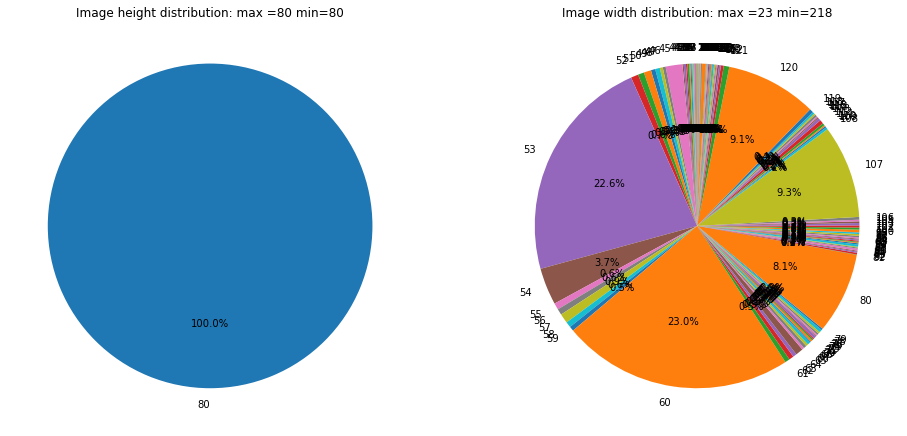

In [6]:
label_height = sorted(df_train['height'].unique())
label_width = sorted(df_train['width'].unique())
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.pie(df_train.groupby('height').size(), labels = label_height, autopct='%1.1f%%', shadow=False, startangle=90)
plt.title("Image height distribution: max ={} min={}".format(df_train["height"].min(),df_train["height"].max()))
plt.subplot(122)
plt.pie(df_train.groupby('width').size(), labels = label_width, autopct='%1.1f%%', shadow=False, startangle=90)
plt.title("Image width distribution: max ={} min={}".format(df_train["width"].min(),df_train["width"].max()))
plt.show()